In [1]:
import os
import cv2 as cv
import sys
import time
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow as tf


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
IMG_CHANNELS = 3

Using TensorFlow backend.


In [2]:
def acc_comp(msk, preds_test_t): #Takes as input 2D masks and 2D predictions
    
    act = msk.reshape(len(msk),1)
    pr = preds_test_t

    c = act == pr #acc
    d = act & pr #true negative
    e = act | pr #true positive
    neg = act.sum()
    pos = (len(act))-act.sum()

    TN = float(d.sum())
    FN = float(pr.sum()-d.sum())
    TP = float((len(act))-e.sum())
    FP = float(e.sum()-pr.sum())
    acc = float(c.sum())/(len(act))

    acc2 = float(TP+TN)/(TP+TN+FP+FN)
#     mean_TP = round(TP/pos,6)
#     mean_TN = round(TN/neg,6)
#     mean_FP = round(FP/pos,6)
#     mean_FN = round(FN/neg,6)
    
    return (acc,TP,TN,FP,FN)

In [3]:
# Define class for extracting time per epoch
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback() 

In [20]:
# Get Training Data (Original+Mask) DONT RUN IN THIS CODE 
# Dataset 1: HGR
TRAIN_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/original_images/']
MASK_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/skin_masks/']
train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
train_ids1.sort()
mask_ids1.sort()
TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
MASK_PATH1 = MASK_PATH1*len(train_ids1)

# Dataset 4: Pratheepan
TRAIN_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
MASK_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
train_ids2.sort()
mask_ids2.sort()
TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
MASK_PATH2 = MASK_PATH2*len(train_ids2)

# Dataset 5: VDM
TRAIN_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/original_images/']
MASK_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/skin_masks/']
train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
train_id3.sort()
mask_id3.sort()
train_ids3 = train_id3[1:]
mask_ids3 = mask_id3[1:]
TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
MASK_PATH3 = MASK_PATH3*len(train_ids3)

# Dataset 6: SFA
TRAIN_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/original_images/']
MASK_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/skin_masks/']
train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
train_ids4.sort()
mask_ids4.sort()
TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
MASK_PATH4 = MASK_PATH4*len(train_ids4)

# Dataset 2: TDSD
TRAIN_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/original_images/']
MASK_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/skin_masks/']
train_ids5 = next(os.walk(TRAIN_PATH5[0]))[2]
mask_ids5 = next(os.walk(MASK_PATH5[0]))[2]
train_ids5.sort()
mask_ids5.sort()
TRAIN_PATH5 = TRAIN_PATH5*len(train_ids5)
MASK_PATH5 = MASK_PATH5*len(train_ids5)

# Dataset 3: Schmugge
TRAIN_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/original_images/']
MASK_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/skin_masks/']
train_ids6 = next(os.walk(TRAIN_PATH6[0]))[2]
mask_ids6 = next(os.walk(MASK_PATH6[0]))[2]
train_ids6.sort()
mask_ids6.sort()
TRAIN_PATH6 = TRAIN_PATH6*len(train_ids6)
MASK_PATH6 = MASK_PATH6*len(train_ids6)

# Dataset 7: FSD
TRAIN_PATH7 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/original_images/']
MASK_PATH7 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/skin_masks/']
train_ids7 = next(os.walk(TRAIN_PATH7[0]))[2]
mask_ids7 = next(os.walk(MASK_PATH7[0]))[2]
train_ids7.sort()
mask_ids7.sort()
TRAIN_PATH7 = TRAIN_PATH7*len(train_ids7)
MASK_PATH7 = MASK_PATH7*len(train_ids7)

# Dataset 8: ABDOMEN
TRAIN_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/skin_train2019/']
MASK_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/annotations/']
train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
train_ids8.sort()
mask_ids8.sort()
# mask_ids8 = mask_id8[:-1]
TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
MASK_PATH8 = MASK_PATH8*len(train_ids8)

# Combine everything
# TRAIN_PATH = np.concatenate((TRAIN_PATH8,TRAIN_PATH2,TRAIN_PATH3,TRAIN_PATH4,TRAIN_PATH5, TRAIN_PATH6,TRAIN_PATH1,TRAIN_PATH7))
# MASK_PATH = np.concatenate((MASK_PATH8,MASK_PATH2,MASK_PATH3,MASK_PATH4,MASK_PATH5,MASK_PATH6,MASK_PATH1,MASK_PATH7))
# train_ids = np.concatenate((train_ids8,train_ids2,train_ids3,train_ids4,train_ids5,train_ids6,train_ids1,train_ids7))
# mask_ids = np.concatenate((mask_ids8,mask_ids2,mask_ids3,mask_ids4,mask_ids5,mask_ids6,mask_ids1,mask_ids7))

TRAIN_PATH = np.concatenate((TRAIN_PATH2,TRAIN_PATH5,TRAIN_PATH4,TRAIN_PATH6,TRAIN_PATH1,TRAIN_PATH7,TRAIN_PATH3))
MASK_PATH = np.concatenate((MASK_PATH2,MASK_PATH5,MASK_PATH4,MASK_PATH6,MASK_PATH1,MASK_PATH7,MASK_PATH3))
train_ids = np.concatenate((train_ids2,train_ids5,train_ids4,train_ids6,train_ids1,train_ids7,train_ids3))
mask_ids = np.concatenate((mask_ids2,mask_ids5,mask_ids4,mask_ids6,mask_ids1,mask_ids7,mask_ids3))

In [19]:
TRAIN_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/skin_train2019/']
MASK_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/annotations/']
train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
train_ids8.sort()
mask_ids8.sort()
# train_ids8 = train_ids8[:-3000]
# mask_ids8 = mask_ids8[:-3000]
# mask_ids8 = mask_id8[:-1]
TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
MASK_PATH8 = MASK_PATH8*len(train_ids8)

TRAIN_PATH = TRAIN_PATH8
train_ids = train_ids8
MASK_PATH = MASK_PATH8
mask_ids= mask_ids8
print(len(train_ids))
print(len(mask_ids))

756
756


In [20]:
 # Extract Features and Corresponding Labels (RUN ONCE ONLY TO GET THE DATA)
print('Getting features and labels from images unreshaped... ')
sys.stdout.flush()

path = TRAIN_PATH[0] + train_ids[0]
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MASK_PATH[0] + mask_ids[0]
img = imread(path)

if img.ndim == 3:
    img = img[:,:,1]
    
# img = img > 30    
# img = img > 0
# img = img.astype(np.uint8)
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH[n] + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MASK_PATH[n] + mask_ids[n]
    img = imread(path)
    if img.ndim == 3:
        img = img[:,:,1]
        
#     img = img > 30     
#     img = img > 0
#     img = img.astype(np.uint8)
        
    L = img.reshape(img.shape[0]*img.shape[1],1)
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))

ABD = dat

Getting features and labels from images unreshaped... 


100%|██████████| 756/756 [04:16<00:00,  2.10it/s]


In [21]:
# print(dat.shape)
# print(np.sum(dat[:,9]))
# np.save('VDM.npy',VDM)
# print(np.unique(dat[:,9]))

(74043165, 10)


In [22]:
# Load the data then shuffle
# ABD = np.load('ABD.npy')
np.random.shuffle(ABD)

# FSD = np.load('FSD.npy')
# FSD = FSD[:4000000]
np.random.shuffle(FSD)

# HGR = np.load('HGR.npy')
np.random.shuffle(HGR)

# Pratheep = np.load('Pratheep.npy')
# np.random.shuffle(Pratheep)

# SCHMG = np.load('SCHMG.npy')
np.random.shuffle(SCHMG)

# SFA = np.load('SFA.npy')
np.random.shuffle(SFA)

# TDSD = np.load('TDSD.npy')
np.random.shuffle(TDSD)

# VDM = np.load('VDM.npy')
np.random.shuffle(VDM)

In [25]:
# Extract and Balance Data
L=np.where(ABD[:,9] > 0)
K = L[0]
skin_abd = ABD[K[:]]
skin_abd = skin_abd[:30000]
L=np.where(ABD[:,9] == 0)
K = L[0]
noskin_abd = ABD[K[:]]
noskin_abd = noskin_abd[:70000]

# L=np.where(FSD[:,9] > 0)
# K = L[0]
# skin_fsd = FSD[K[:]]
# skin_fsd = skin_fsd[:30000]
# L=np.where(FSD[:,9] == 0)
# K = L[0]
# noskin_fsd = FSD[K[:]]
# noskin_fsd = noskin_fsd[:70000]

L=np.where(HGR[:,9] > 0)
K = L[0]
skin_hgr = HGR[K[:]]
skin_hgr = skin_hgr[:60000]
L=np.where(HGR[:,9] == 0)
K = L[0]
noskin_hgr = HGR[K[:]]
noskin_hgr = noskin_hgr[:140000]

# L=np.where(Pratheep[:,9] > 0)
# K = L[0]
# skin_pra = Pratheep[K[:]]
# skin_pra = skin_pra[:30000]
# L=np.where(Pratheep[:,9] == 0)
# K = L[0]
# noskin_pra = Pratheep[K[:]]
# noskin_pra = noskin_pra[:70000]

L=np.where(SCHMG[:,9] > 0)
K = L[0]
skin_schmg = SCHMG[K[:]]
skin_schmg = skin_schmg[:60000]
L=np.where(SCHMG[:,9] == 0)
K = L[0]
noskin_schmg = SCHMG[K[:]]
noskin_schmg = noskin_schmg[:140000]

L=np.where(SFA[:,9] > 0)
K = L[0]
skin_sfa = SFA[K[:]]
skin_sfa = skin_sfa[:60000]
L=np.where(SFA[:,9] == 0)
K = L[0]
noskin_sfa = SFA[K[:]]
noskin_sfa = noskin_sfa[:140000]

L=np.where(TDSD[:,9] > 0)
K = L[0]
skin_tdsd = TDSD[K[:]]
skin_tdsd = skin_tdsd[:60000]
L=np.where(TDSD[:,9] == 0)
K = L[0]
noskin_tdsd = TDSD[K[:]]
noskin_tdsd = noskin_tdsd[:140000]

L=np.where(VDM[:,9] > 0)
K = L[0]
skin_vdm = VDM[K[:]]
skin_vdm = skin_vdm[:60000]
L=np.where(VDM[:,9] == 0)
K = L[0]
noskin_vdm = VDM[K[:]]
noskin_vdm = noskin_vdm[:140000]

In [25]:
# Load Shuffled data
alldata = np.concatenate((ABD,FSD,HGR,VDM,SCHMG,SFA,TDSD,VDM), axis = 0)
# alldata = np.concatenate((skin_abd,skin_hgr,skin_schmg,skin_sfa,skin_tdsd,skin_vdm,noskin_abd,noskin_hgr,noskin_schmg,noskin_sfa,noskin_tdsd,noskin_vdm), axis = 0)
# np.random.shuffle(alldata)
take = alldata[:2000000]
print(take.shape)
feat = take[:,:9]
labels = take[:,9]
labels = (labels > 0).astype(np.uint8)

(2000000, 10)


In [ ]:
# Build the network
model = Sequential()
model.add(Dense(9, input_dim=9, activation='relu'))
model.add(Dropout(0.2, input_shape=(9,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2, input_shape=(32,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2, input_shape=(256,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2, input_shape=(32,)))
model.add(Dense(9, activation='relu'))
model.add(Dropout(0.2, input_shape=(9,)))
model.add(Dense(1, activation='sigmoid'))

checkpointer = ModelCheckpoint('model-testall-26Mar2019.h5', verbose=1, save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

results = model.fit(feat, labels, validation_split=0.2, epochs=50, batch_size=64, shuffle=True, 
          callbacks=[checkpointer, cb])

Train on 1600000 samples, validate on 400000 samples
Epoch 1/50
1600000/1600000 [==============================] - 188s 117us/step - loss: 0.2445 - acc: 0.9085 - val_loss: 0.2024 - val_acc: 0.9306

Epoch 00001: val_loss improved from inf to 0.20238, saving model to model-testall-26Mar2019.h5
Epoch 2/50
1600000/1600000 [==============================] - 185s 116us/step - loss: 0.2239 - acc: 0.9201 - val_loss: 0.2166 - val_acc: 0.9324

Epoch 00002: val_loss did not improve from 0.20238
Epoch 3/50
1600000/1600000 [==============================] - 185s 116us/step - loss: 0.2236 - acc: 0.9212 - val_loss: 0.2143 - val_acc: 0.9321

Epoch 00003: val_loss did not improve from 0.20238
Epoch 4/50
1600000/1600000 [==============================] - 184s 115us/step - loss: 0.2214 - acc: 0.9218 - val_loss: 0.2387 - val_acc: 0.9336

Epoch 00004: val_loss did not improve from 0.20238
Epoch 5/50
1600000/1600000 [==============================] - 185s 115us/step - loss: 0.2213 - acc: 0.9225 - val_loss: 

In [ ]:
#print(results.history.keys())

# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for mean_iou
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 64)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

ep = 50;
a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]
e = cb.times
print ("-------------------------------------------------------------")
header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
print(header)
print ("-------------------------------------------------------------")
for l in range(ep):
    str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
    print (str.expandtabs(2))
print ("-------------------------------------------------------------")

In [32]:
# Evaluate the model
model = load_model('model-testall-26Mar2019.h5')
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Compute Accuracy for Abdomen Set
ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/skin_val2019/'
MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/annotations/'
abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()

print('Getting features and labels from images unreshaped... ')
sys.stdout.flush()

path = ABD_PATH + abd_ids[0]
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MSK_PATH + msk_ids[0]
img = imread(path)

if img.ndim == 3:
    img = img[:,:,1]
    
img = img > 30    
img = img > 0
img = img.astype(np.uint8)
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + abd_ids[n]
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MSK_PATH + msk_ids[n]
    img = imread(path)

    if img.ndim == 3:
        img = img[:,:,1]
    
    img = img > 30    
    img = img > 0
    img = img.astype(np.uint8)
    L = img.reshape(img.shape[0]*img.shape[1],1)
    
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))
   
X = dat[:,0:9]
Y = dat[:,9]

scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Getting features and labels from images unreshaped... 




  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:06, 14.85it/s]

  4%|▍         | 4/100 [00:00<00:10,  8.78it/s]

  6%|▌         | 6/100 [00:00<00:09,  9.91it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.13it/s]

 10%|█         | 10/100 [00:00<00:07, 12.22it/s]

 12%|█▏        | 12/100 [00:01<00:06, 13.08it/s]

 14%|█▍        | 14/100 [00:01<00:06, 13.63it/s]

 16%|█▌        | 16/100 [00:01<00:05, 14.09it/s]

 18%|█▊        | 18/100 [00:01<00:05, 14.39it/s]

 20%|██        | 20/100 [00:01<00:05, 14.58it/s]

 22%|██▏       | 22/100 [00:01<00:05, 14.59it/s]

 24%|██▍       | 24/100 [00:01<00:05, 14.65it/s]

 26%|██▌       | 26/100 [00:02<00:05, 14.64it/s]

 28%|██▊       | 28/100 [00:02<00:04, 14.62it/s]

 30%|███       | 30/100 [00:02<00:04, 14.57it/s]

 32%|███▏      | 32/100 [00:02<00:04, 14.50it/s]

 34%|███▍      | 34/100 [00:02<00:04, 14.42it/s]

 36%|███▌      | 36/100 [00:02<00:04, 14.33it/s]

 38%|███▊      | 38/100 [00:02<00:04, 14.21it/s]

 40%|████  

14975050/14975050 [==============================] - 900s 60us/step

acc: 94.35%


In [29]:
# scores = model.evaluate(X, Y)
# preds_test = model.predict(X, verbose=1)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Evaluate the model
model = load_model('model-masturbation-11Feb2019.h5')
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Compute Accuracy for Abdomen Set
ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/skin_val2019/'
MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/annotations/'
abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()
# abd_ids = abd_ids[-100:]
# msk_ids = msk_ids[-100:]

# Actual Predictions
N = np.zeros((1,4))

for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + abd_ids[n]
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MSK_PATH + msk_ids[n]
    img = imread(path)

    if img.ndim == 3:
        img = img[:,:,1]
    
    img = img > 30    
#     img = img > 0
    img = img.astype(np.uint8)
    L = img.reshape(img.shape[0]*img.shape[1],1)
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    
    X = dat_temp[:,0:9]
    Y = dat_temp[:,9]
    
    preds_test = model.predict(X[:int(X.shape[0])], verbose=1)

    # Threshold predictions
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    answer = acc_comp(Y, preds_test_t)

    a = answer[1]
    b = answer[2]
    c = answer[3]
    d = answer[4]

    K = np.array((a,b,c,d)).reshape(1,4)
    N = np.concatenate((N,K),axis = 0)
#     print(N)



  0%|          | 0/100 [00:00<?, ?it/s]

235872/235872 [==============================] - 12s 50us/step




  1%|          | 1/100 [00:11<19:37, 11.89s/it]

2064000/2064000 [==============================] - 100s 49us/step




  2%|▏         | 2/100 [01:52<1:02:50, 38.47s/it]

674520/674520 [==============================] - 33s 49us/step




  3%|▎         | 3/100 [02:25<59:26, 36.76s/it]  

6553600/6553600 [==============================] - 315s 48us/step




  4%|▍         | 4/100 [07:40<3:12:43, 120.46s/it]

247860/247860 [==============================] - 12s 47us/step




  5%|▌         | 5/100 [07:52<2:19:05, 87.85s/it] 

119600/119600 [==============================] - 6s 47us/step




  6%|▌         | 6/100 [07:58<1:38:59, 63.19s/it]

51529/51529 [==============================] - 2s 47us/step




  7%|▋         | 7/100 [08:00<1:09:41, 44.96s/it]

51529/51529 [==============================] - 2s 47us/step




  8%|▊         | 8/100 [08:03<49:23, 32.21s/it]  

51529/51529 [==============================] - 2s 47us/step




  9%|▉         | 9/100 [08:05<35:18, 23.28s/it]

51529/51529 [==============================] - 2s 47us/step




 10%|█         | 10/100 [08:08<25:32, 17.02s/it]

51529/51529 [==============================] - 2s 48us/step




 11%|█         | 11/100 [08:10<18:46, 12.66s/it]

51529/51529 [==============================] - 2s 48us/step




 12%|█▏        | 12/100 [08:13<14:05,  9.61s/it]

51529/51529 [==============================] - 2s 47us/step




 13%|█▎        | 13/100 [08:15<10:48,  7.45s/it]

51529/51529 [==============================] - 2s 47us/step




 14%|█▍        | 14/100 [08:17<08:31,  5.94s/it]

51529/51529 [==============================] - 2s 48us/step




 15%|█▌        | 15/100 [08:20<06:57,  4.91s/it]

51529/51529 [==============================] - 2s 46us/step




 16%|█▌        | 16/100 [08:22<05:49,  4.16s/it]

51529/51529 [==============================] - 2s 47us/step




 17%|█▋        | 17/100 [08:25<05:01,  3.63s/it]

51529/51529 [==============================] - 2s 47us/step




 18%|█▊        | 18/100 [08:27<04:27,  3.27s/it]

51529/51529 [==============================] - 2s 47us/step




 19%|█▉        | 19/100 [08:30<04:04,  3.01s/it]

51529/51529 [==============================] - 2s 48us/step




 20%|██        | 20/100 [08:32<03:47,  2.85s/it]

51529/51529 [==============================] - 2s 47us/step




 21%|██        | 21/100 [08:34<03:35,  2.73s/it]

51529/51529 [==============================] - 2s 47us/step




 22%|██▏       | 22/100 [08:37<03:26,  2.65s/it]

51529/51529 [==============================] - 2s 47us/step




 23%|██▎       | 23/100 [08:39<03:19,  2.59s/it]

51529/51529 [==============================] - 2s 47us/step




 24%|██▍       | 24/100 [08:42<03:13,  2.55s/it]

51529/51529 [==============================] - 2s 47us/step




 25%|██▌       | 25/100 [08:44<03:08,  2.52s/it]

51529/51529 [==============================] - 2s 47us/step




 26%|██▌       | 26/100 [08:47<03:04,  2.49s/it]

51529/51529 [==============================] - 2s 47us/step




 27%|██▋       | 27/100 [08:49<03:00,  2.47s/it]

51529/51529 [==============================] - 2s 48us/step




 28%|██▊       | 28/100 [08:52<02:57,  2.47s/it]

51529/51529 [==============================] - 2s 47us/step




 29%|██▉       | 29/100 [08:54<02:54,  2.46s/it]

51529/51529 [==============================] - 2s 47us/step




 30%|███       | 30/100 [08:56<02:52,  2.46s/it]

51529/51529 [==============================] - 2s 47us/step




 31%|███       | 31/100 [08:59<02:49,  2.45s/it]

51529/51529 [==============================] - 2s 47us/step




 32%|███▏      | 32/100 [09:01<02:46,  2.45s/it]

51529/51529 [==============================] - 2s 47us/step




 33%|███▎      | 33/100 [09:04<02:44,  2.45s/it]

51529/51529 [==============================] - 2s 48us/step




 34%|███▍      | 34/100 [09:06<02:42,  2.46s/it]

51529/51529 [==============================] - 2s 47us/step




 35%|███▌      | 35/100 [09:09<02:39,  2.46s/it]

51529/51529 [==============================] - 2s 48us/step




 36%|███▌      | 36/100 [09:11<02:37,  2.46s/it]

51529/51529 [==============================] - 2s 47us/step




 37%|███▋      | 37/100 [09:14<02:34,  2.46s/it]

51529/51529 [==============================] - 2s 46us/step




 38%|███▊      | 38/100 [09:16<02:31,  2.44s/it]

51529/51529 [==============================] - 2s 47us/step




 39%|███▉      | 39/100 [09:18<02:28,  2.43s/it]

51529/51529 [==============================] - 2s 47us/step




 40%|████      | 40/100 [09:21<02:26,  2.44s/it]

51529/51529 [==============================] - 2s 47us/step




 41%|████      | 41/100 [09:23<02:23,  2.43s/it]

51529/51529 [==============================] - 2s 45us/step




 42%|████▏     | 42/100 [09:26<02:18,  2.39s/it]

51529/51529 [==============================] - 2s 45us/step




 43%|████▎     | 43/100 [09:28<02:15,  2.37s/it]

51529/51529 [==============================] - 2s 45us/step




 44%|████▍     | 44/100 [09:30<02:11,  2.35s/it]

51529/51529 [==============================] - 2s 45us/step




 45%|████▌     | 45/100 [09:33<02:08,  2.34s/it]

51529/51529 [==============================] - 2s 45us/step




 46%|████▌     | 46/100 [09:35<02:06,  2.34s/it]

51529/51529 [==============================] - 2s 45us/step




 47%|████▋     | 47/100 [09:37<02:03,  2.33s/it]

51529/51529 [==============================] - 2s 45us/step




 48%|████▊     | 48/100 [09:40<02:01,  2.33s/it]

51529/51529 [==============================] - 2s 45us/step




 49%|████▉     | 49/100 [09:42<01:58,  2.32s/it]

51529/51529 [==============================] - 2s 45us/step




 50%|█████     | 50/100 [09:44<01:56,  2.32s/it]

51529/51529 [==============================] - 2s 45us/step




 51%|█████     | 51/100 [09:47<01:53,  2.32s/it]

51529/51529 [==============================] - 2s 44us/step




 52%|█████▏    | 52/100 [09:49<01:51,  2.32s/it]

51529/51529 [==============================] - 2s 47us/step




 53%|█████▎    | 53/100 [09:51<01:50,  2.36s/it]

51529/51529 [==============================] - 2s 46us/step




 54%|█████▍    | 54/100 [09:54<01:48,  2.37s/it]

51529/51529 [==============================] - 2s 47us/step




 55%|█████▌    | 55/100 [09:56<01:47,  2.38s/it]

51529/51529 [==============================] - 2s 47us/step




 56%|█████▌    | 56/100 [09:59<01:45,  2.40s/it]

51529/51529 [==============================] - 2s 48us/step




 57%|█████▋    | 57/100 [10:01<01:44,  2.42s/it]

51529/51529 [==============================] - 2s 48us/step




 58%|█████▊    | 58/100 [10:03<01:42,  2.44s/it]

51529/51529 [==============================] - 2s 47us/step




 59%|█████▉    | 59/100 [10:06<01:40,  2.44s/it]

51529/51529 [==============================] - 2s 47us/step




 60%|██████    | 60/100 [10:08<01:37,  2.45s/it]

51529/51529 [==============================] - 2s 47us/step




 61%|██████    | 61/100 [10:11<01:35,  2.45s/it]

51529/51529 [==============================] - 2s 47us/step




 62%|██████▏   | 62/100 [10:13<01:33,  2.45s/it]

51529/51529 [==============================] - 2s 47us/step




 63%|██████▎   | 63/100 [10:16<01:30,  2.45s/it]

51529/51529 [==============================] - 2s 48us/step




 64%|██████▍   | 64/100 [10:18<01:28,  2.46s/it]

51529/51529 [==============================] - 2s 47us/step




 65%|██████▌   | 65/100 [10:21<01:25,  2.46s/it]

51529/51529 [==============================] - 2s 48us/step




 66%|██████▌   | 66/100 [10:23<01:23,  2.46s/it]

51529/51529 [==============================] - 2s 47us/step




 67%|██████▋   | 67/100 [10:26<01:21,  2.46s/it]

51529/51529 [==============================] - 2s 48us/step




 68%|██████▊   | 68/100 [10:28<01:18,  2.46s/it]

51529/51529 [==============================] - 2s 47us/step




 69%|██████▉   | 69/100 [10:30<01:15,  2.45s/it]

51529/51529 [==============================] - 2s 45us/step




 70%|███████   | 70/100 [10:33<01:12,  2.42s/it]

51529/51529 [==============================] - 2s 46us/step




 71%|███████   | 71/100 [10:35<01:09,  2.40s/it]

51529/51529 [==============================] - 2s 46us/step




 72%|███████▏  | 72/100 [10:38<01:06,  2.39s/it]

51529/51529 [==============================] - 2s 46us/step




 73%|███████▎  | 73/100 [10:40<01:04,  2.38s/it]

51529/51529 [==============================] - 2s 46us/step




 74%|███████▍  | 74/100 [10:42<01:01,  2.38s/it]

51529/51529 [==============================] - 2s 46us/step




 75%|███████▌  | 75/100 [10:45<00:59,  2.39s/it]

51529/51529 [==============================] - 2s 47us/step




 76%|███████▌  | 76/100 [10:47<00:57,  2.41s/it]

51529/51529 [==============================] - 2s 47us/step




 77%|███████▋  | 77/100 [10:50<00:55,  2.42s/it]

51529/51529 [==============================] - 2s 48us/step




 78%|███████▊  | 78/100 [10:52<00:53,  2.43s/it]

51529/51529 [==============================] - 2s 47us/step




 79%|███████▉  | 79/100 [10:55<00:51,  2.44s/it]

51529/51529 [==============================] - 2s 48us/step




 80%|████████  | 80/100 [10:57<00:48,  2.45s/it]

51529/51529 [==============================] - 2s 47us/step




 81%|████████  | 81/100 [10:59<00:46,  2.45s/it]

51529/51529 [==============================] - 2s 47us/step




 82%|████████▏ | 82/100 [11:02<00:44,  2.45s/it]

51529/51529 [==============================] - 2s 48us/step




 83%|████████▎ | 83/100 [11:04<00:41,  2.45s/it]

51529/51529 [==============================] - 2s 47us/step




 84%|████████▍ | 84/100 [11:07<00:39,  2.45s/it]

51529/51529 [==============================] - 2s 47us/step




 85%|████████▌ | 85/100 [11:09<00:36,  2.45s/it]

51529/51529 [==============================] - 2s 47us/step




 86%|████████▌ | 86/100 [11:12<00:34,  2.45s/it]

51529/51529 [==============================] - 2s 46us/step




 87%|████████▋ | 87/100 [11:14<00:31,  2.42s/it]

51529/51529 [==============================] - 2s 46us/step




 88%|████████▊ | 88/100 [11:16<00:28,  2.41s/it]

51529/51529 [==============================] - 2s 47us/step




 89%|████████▉ | 89/100 [11:19<00:26,  2.42s/it]

51529/51529 [==============================] - 2s 47us/step




 90%|█████████ | 90/100 [11:21<00:24,  2.42s/it]

51529/51529 [==============================] - 2s 47us/step




 91%|█████████ | 91/100 [11:24<00:21,  2.43s/it]

51529/51529 [==============================] - 2s 47us/step




 92%|█████████▏| 92/100 [11:26<00:19,  2.43s/it]

51529/51529 [==============================] - 2s 47us/step




 93%|█████████▎| 93/100 [11:29<00:17,  2.44s/it]

51529/51529 [==============================] - 2s 47us/step




 94%|█████████▍| 94/100 [11:31<00:14,  2.44s/it]

51529/51529 [==============================] - 2s 47us/step




 95%|█████████▌| 95/100 [11:34<00:12,  2.44s/it]

51529/51529 [==============================] - 2s 47us/step




 96%|█████████▌| 96/100 [11:36<00:09,  2.44s/it]

51529/51529 [==============================] - 2s 47us/step




 97%|█████████▋| 97/100 [11:38<00:07,  2.44s/it]

51529/51529 [==============================] - 2s 47us/step




 98%|█████████▊| 98/100 [11:41<00:04,  2.44s/it]

51529/51529 [==============================] - 2s 47us/step




 99%|█████████▉| 99/100 [11:43<00:02,  2.44s/it]

51529/51529 [==============================] - 2s 47us/step




100%|██████████| 100/100 [11:46<00:00,  2.44s/it]

In [31]:
# Overall accuracy on abdomen pictures
# answer = acc_comp(Y, preds_test_t)

# a = answer[1]
# b = answer[2]
# c = answer[3]
# d = answer[4]
# K = np.array((a,b,c,d)).reshape(1,4)
# print(K.shape)

# N = np.zeros((1,4))
# N = np.concatenate((N,K),axis = 0)
out = N[1:]
j = (out[:,0]+out[:,1])/(out[:,0]+out[:,1]+out[:,2]+out[:,3])
print(np.mean(j))
np.save('NEWABD.npy',out)

0.855066805433738


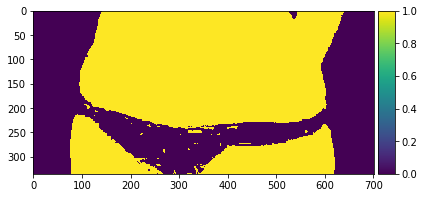

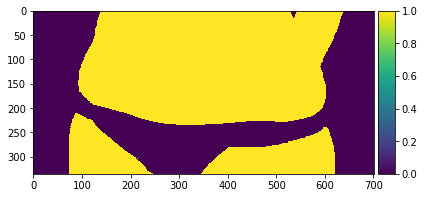

In [75]:
output = np.reshape(preds_test_t,(img.shape[0],img.shape[1]))
plt.show()
imshow(output)
plt.show()
imshow(img)

In [ ]:
feat = dat[0:800000,0:9]
labels = dat[0:800000,9]
labels = (labels > 0).astype(np.uint8)
print(feat.shape)
print(labels.shape)
X = dat[800000:,0:9]
Y = dat[800000:,9]
Y = (Y > 0).astype(np.uint8) 
print(X.shape)
print(Y.shape)